# Multi Investment Optimization

In the following, we show how PyPSA can deal with multi-investment optimization, also known as multi-horizon optimization. 

Here, the total set of snapshots is divided into investment periods. For the model, this translates into multi-indexed snapshots with the first level being the investment period and the second level the according time steps. In each investment period new asset may be added to the system. On the other hand assets may only operate as long as allowed by their lifetime.

In contrast to the ordinary optimisation, the following concepts have to be taken into account. 

1. `investment_periods` - `pypsa.Network` attribute. This is the set of periods which specify when new assets may be built. In the current implementation, these have to be the same as the first level values in the `snapshots` attribute.
2. `investment_period_weightings` - `pypsa.Network` attribute. These specify the weighting of each period in the objective function. 
3. `build_year` - general component attribute. A single asset may only be built when the build year is smaller or equal to the current investment period. For example, assets with a build year `2029` are considered in the investment period `2030`, but not in the period `2025`.  
4. `lifetime` - general component attribute. An asset is only considered in an investment period if present at the beginning of an investment period. For example, an asset with build year `2029` and lifetime `30` is considered in the investment period `2055` but not in the period `2060`.   

In the following, we set up a three node network with generators, lines and storages and run a optimisation covering the time span from 2020 to 2050 and each decade is one investment period.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pypsa

rng = np.random.default_rng()  # Create a random number generator

We set up the network with investment periods and snapshots. 

In [2]:
n = pypsa.Network()
years = [2020, 2030, 2040, 2050]
freq = "24"

snapshots = pd.DatetimeIndex([])
for year in years:
    period = pd.date_range(
        start=f"{year}-01-01 00:00",
        freq=f"{freq}H",
        periods=8760 / float(freq),
    )
    snapshots = snapshots.append(period)

# convert to multiindex and assign to network
n.snapshots = pd.MultiIndex.from_arrays([snapshots.year, snapshots])
n.investment_periods = years

n.snapshot_weightings

C:\Users\dell\AppData\Local\Temp\ipykernel_23820\981291686.py:7: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a future version.
  period = pd.date_range(
C:\Users\dell\AppData\Local\Temp\ipykernel_23820\981291686.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  period = pd.date_range(


objective  stores  generators
period timestep                                 
2020   2020-01-01        1.0     1.0         1.0
       2020-01-02        1.0     1.0         1.0
       2020-01-03        1.0     1.0         1.0
       2020-01-04        1.0     1.0         1.0
       2020-01-05        1.0     1.0         1.0
...                      ...     ...         ...
2050   2050-12-27        1.0     1.0         1.0
       2050-12-28        1.0     1.0         1.0
       2050-12-29        1.0     1.0         1.0
       2050-12-30        1.0     1.0         1.0
       2050-12-31        1.0     1.0         1.0

[1460 rows x 3 columns]

In [3]:
n.investment_periods

Index([2020, 2030, 2040, 2050], dtype='int64')

Set the years and objective weighting per investment period. For the objective weighting, we consider a discount rate defined by 
$$ D(t) = \dfrac{1}{(1+r)^t} $$ 

where $r$ is the discount rate. For each period we sum up all discounts rates of the corresponding years which gives us the effective objective weighting.

In [4]:
n.investment_period_weightings["years"] = list(np.diff(years)) + [10]

r = 0.01
T = 0
for period, nyears in n.investment_period_weightings.years.items():
    discounts = [(1 / (1 + r) ** t) for t in range(T, T + nyears)]
    n.investment_period_weightings.at[period, "objective"] = sum(discounts)
    T += nyears
n.investment_period_weightings

,objective,years
2020,9.566018,10
2030,8.659991,10
2040,7.839777,10
2050,7.097248,10


Add the components

In [5]:
for i in range(3):
    n.add("Bus", f"bus {i}")

# add three lines in a ring
n.add(
    "Line",
    "line 0->1",
    bus0="bus 0",
    bus1="bus 1",
)

n.add(
    "Line",
    "line 1->2",
    bus0="bus 1",
    bus1="bus 2",
    capital_cost=10,
    build_year=2030,
)

n.add(
    "Line",
    "line 2->0",
    bus0="bus 2",
    bus1="bus 0",
)

n.lines["x"] = 0.0001
n.lines["s_nom_extendable"] = True

In [6]:
n.lines

,bus0,bus1,type,x,r,g,b,s_nom,s_nom_mod,s_nom_extendable,...,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt
Line,,,,,,,,,,,,,,,,,,,,,
line 0->1,bus 0,bus 1,,0.0001,0.0,0.0,0.0,0.0,0.0,True,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
line 1->2,bus 1,bus 2,,0.0001,0.0,0.0,0.0,0.0,0.0,True,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
line 2->0,bus 2,bus 0,,0.0001,0.0,0.0,0.0,0.0,0.0,True,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# add some generators
p_nom_max = pd.Series(
    (rng.uniform() for sn in range(len(n.snapshots))),
    index=n.snapshots,
    name="generator ext 2020",
)

# renewable (can operate 2020, 2030)
n.add(
    "Generator",
    "generator ext 0 2020",
    bus="bus 0",
    p_nom=50,
    build_year=2020,
    lifetime=20,
    marginal_cost=2,
    capital_cost=1,
    p_max_pu=p_nom_max,
    carrier="solar",
    p_nom_extendable=True,
)

# can operate 2040, 2050
n.add(
    "Generator",
    "generator ext 0 2040",
    bus="bus 0",
    p_nom=50,
    build_year=2040,
    lifetime=11,
    marginal_cost=25,
    capital_cost=10,
    carrier="OCGT",
    p_nom_extendable=True,
)

# can operate in 2040
n.add(
    "Generator",
    "generator fix 1 2040",
    bus="bus 1",
    p_nom=50,
    build_year=2040,
    lifetime=10,
    carrier="CCGT",
    marginal_cost=20,
    capital_cost=1,
)

n.generators

,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
generator ext 0 2020,bus 0,PQ,,50.0,0.0,True,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
generator ext 0 2040,bus 0,PQ,,50.0,0.0,True,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
generator fix 1 2040,bus 1,PQ,,50.0,0.0,False,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0


In [8]:
n.add(
    "StorageUnit",
    "storageunit non-cyclic 2030",
    bus="bus 2",
    p_nom=0,
    capital_cost=2,
    build_year=2030,
    lifetime=21,
    cyclic_state_of_charge=False,
    p_nom_extendable=False,
)

n.add(
    "StorageUnit",
    "storageunit periodic 2020",
    bus="bus 2",
    p_nom=0,
    capital_cost=1,
    build_year=2020,
    lifetime=21,
    cyclic_state_of_charge=True,
    cyclic_state_of_charge_per_period=True,
    p_nom_extendable=True,
)

n.storage_units

,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,state_of_charge_initial_per_period,state_of_charge_set,cyclic_state_of_charge,cyclic_state_of_charge_per_period,max_hours,efficiency_store,efficiency_dispatch,standing_loss,inflow,p_nom_opt
StorageUnit,,,,,,,,,,,,,,,,,,,,,
storageunit non-cyclic 2030,bus 2,PQ,,0.0,0.0,False,0.0,inf,-1.0,1.0,...,False,NaN,False,True,1.0,1.0,1.0,0.0,0.0,0.0
storageunit periodic 2020,bus 2,PQ,,0.0,0.0,True,0.0,inf,-1.0,1.0,...,False,NaN,True,True,1.0,1.0,1.0,0.0,0.0,0.0


Add the load

In [9]:
load_var = pd.Series(
    100 * rng.random(size=len(n.snapshots)), index=n.snapshots, name="load"
)
n.add("Load", "load 2", bus="bus 2", p_set=load_var)

load_fix = pd.Series(75, index=n.snapshots, name="load")
n.add("Load", "load 1", bus="bus 1", p_set=load_fix)

Index(['load 1'], dtype='object')

Run the optimization

In [10]:
n.loads_t.p_set

Load               load 1     load 2
period timestep                     
2020   2020-01-01    75.0   7.008168
       2020-01-02    75.0  58.022417
       2020-01-03    75.0  34.286488
       2020-01-04    75.0  47.643671
       2020-01-05    75.0  98.624972
...                   ...        ...
2050   2050-12-27    75.0  66.930793
       2050-12-28    75.0   8.161956
       2050-12-29    75.0  36.640972
       2050-12-30    75.0  68.351785
       2050-12-31    75.0  93.358265

[1460 rows x 2 columns]

In [11]:
n.optimize(multi_investment_periods=True)

Index(['line 0->1', 'line 1->2', 'line 2->0'], dtype='object', name='Line')
Index(['line 0->1', 'line 1->2', 'line 2->0'], dtype='object', name='Line')
Index(['bus 0', 'bus 1', 'bus 2'], dtype='object', name='Bus')
Index(['generator ext 0 2020', 'generator ext 0 2040', 'generator fix 1 2040'], dtype='object', name='Generator')
Index(['line 0->1', 'line 1->2', 'line 2->0'], dtype='object', name='Line')
Index(['line 0->1', 'line 1->2', 'line 2->0'], dtype='object', name='Line')
Index(['bus 0', 'bus 1', 'bus 2'], dtype='object', name='Bus')
Index(['generator ext 0 2020', 'generator ext 0 2040', 'generator fix 1 2040'], dtype='object', name='Generator')
C:\Users\dell\AppData\Roaming\Python\Python312\site-packages\linopy\common.py:147: UserWarning: coords for dimension(s) ['Generator'] is not aligned with the pandas object. Previously, the indexes of the pandas were ignored and overwritten in these cases. Now, the pandas object's coordinates are taken considered for alignment.
  warn(
INFO:

('ok', 'optimal')

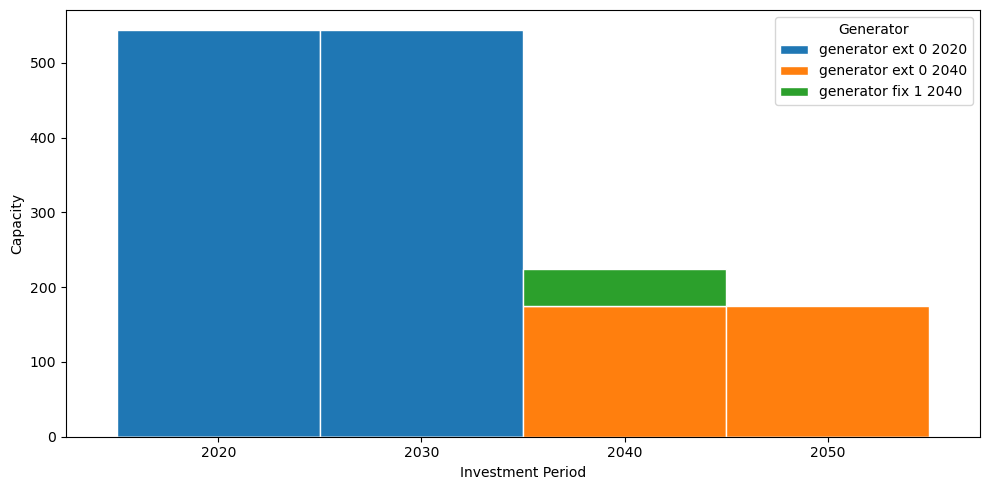

In [12]:
c = "Generator"
df = pd.concat(
    {
        period: n.get_active_assets(c, period) * n.static(c).p_nom_opt
        for period in n.investment_periods
    },
    axis=1,
)
df.T.plot.bar(
    stacked=True,
    edgecolor="white",
    width=1,
    ylabel="Capacity",
    xlabel="Investment Period",
    rot=0,
    figsize=(10, 5),
)
plt.tight_layout()

<Axes: xlabel='Investment Period', ylabel='Generation'>

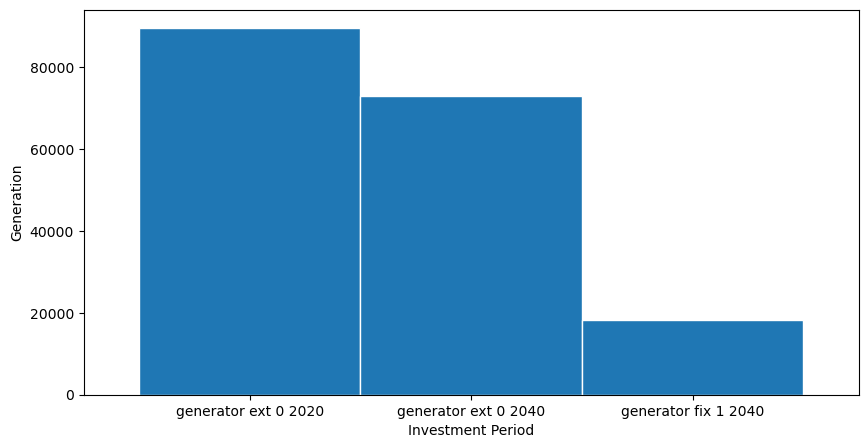

In [13]:
df = n.generators_t.p.sum(axis=0).T
df.T.plot.bar(
    stacked=True,
    edgecolor="white",
    width=1,
    ylabel="Generation",
    xlabel="Investment Period",
    rot=0,
    figsize=(10, 5),
)